# Portfolio Project 1: Attention Heatmaps

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import matplotlib.pyplot as plt

torch.manual_seed(42)

In [4]:
# simple tokenizer
sentence = "snow melts in warm spring sunlight"
tokens = sentence.lower().split()
seq_len = len(tokens)

print("Tokens:", tokens)

Tokens: ['snow', 'melts', 'in', 'warm', 'spring', 'sunlight']


In [5]:
# create vocab
vocab = {word: i for i, word in enumerate(tokens)}
vocab_size = len(vocab)

# embeddings
d_model = 64
token_ids = torch.tensor([vocab[word] for word in tokens])
embedding = nn.Embedding(vocab_size, d_model)
X_embed = embedding(token_ids)  # (seq_len, d_model)

In [6]:
# add positional encodings 
def positional_encoding(seq_len, d_model):
    pe = torch.zeros(seq_len, d_model)
    for pos in range(seq_len):
        for i in range(0, d_model, 2):
            pe[pos, i] = math.sin(pos / (10000 ** (2*i/d_model)))
            pe[pos, i+1] = math.cos(pos / (10000 ** (2*(i+1)/d_model)))
    return pe

PE = positional_encoding(seq_len, d_model)

X_with_pos = X_embed + PE
X_no_pos = X_embed.clone()

# add batch dimension
X_with_pos = X_with_pos.unsqueeze(0)
X_no_pos = X_no_pos.unsqueeze(0)

In [7]:
# attention model from lab 3
class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        assert embed_dim % num_heads == 0
        
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        self.W_q = nn.Linear(embed_dim, embed_dim)
        self.W_k = nn.Linear(embed_dim, embed_dim)
        self.W_v = nn.Linear(embed_dim, embed_dim)
        self.W_o = nn.Linear(embed_dim, embed_dim)

    def forward(self, x, return_scores=False):
        batch_size, seq_len, _ = x.size()

        Q = self.W_q(x)
        K = self.W_k(x)
        V = self.W_v(x)

        Q = Q.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1,2)
        K = K.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1,2)
        V = V.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1,2)

        scores = torch.matmul(Q, K.transpose(-2,-1)) / math.sqrt(self.head_dim)
        weights = F.softmax(scores, dim=-1)

        out = torch.matmul(weights, V)
        out = out.transpose(1,2).contiguous().view(batch_size, seq_len, self.embed_dim)

        if return_scores:
            return self.W_o(out), weights, scores
        
        return self.W_o(out), weights

In [8]:
mha = MultiHeadAttention(embed_dim=64, num_heads=4)

output_pos, weights_pos = mha(X_with_pos)
output_no_pos, weights_no_pos = mha(X_no_pos)

In [9]:
print("Attention shape:", weights_pos.shape)
# (batch, heads, seq_len, seq_len)

Attention shape: torch.Size([1, 4, 6, 6])


### Multi-head Attention

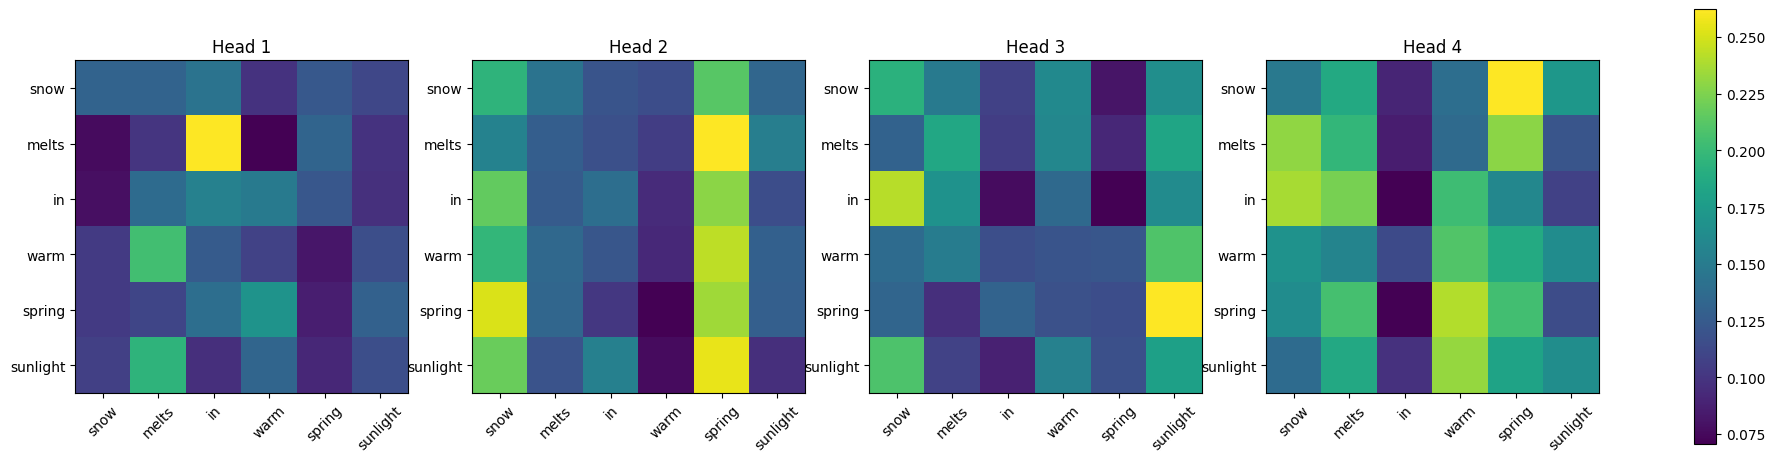

In [13]:
weights = weights_pos[0]  # remove batch dim

fig, axes = plt.subplots(1, weights.shape[0], figsize=(20,5))

for h in range(weights.shape[0]):
    ax = axes[h]
    ax.imshow(weights[h].detach().numpy(), cmap="viridis")
    ax.set_xticks(range(seq_len))
    ax.set_yticks(range(seq_len))
    ax.set_xticklabels(tokens, rotation=45)
    ax.set_yticklabels(tokens)
    ax.set_title(f"Head {h+1}")

plt.tight_layout()
plt.colorbar(ax.images[0], ax=axes.ravel().tolist())
plt.savefig("C:\\Users\\mamar\\portfolio-piece-1-mmarchio29\\attention-portfolio\\outputs\\multihead_attention.png", dpi=300, bbox_inches="tight")
plt.show()

### Scaling vs. No Scaling

In [14]:
# simple attention function with optional scaling
def attention(Q, K, V, scale=True):
    d_k = Q.size(-1)
    scores = torch.matmul(Q, K.transpose(-2,-1))
    if scale:
        scores = scores / math.sqrt(d_k)
    weights = F.softmax(scores, dim=-1)
    output = torch.matmul(weights, V)
    
    return weights, scores

In [15]:
# use existing projections
Q = mha.W_q(X_with_pos)
K = mha.W_k(X_with_pos)
V = mha.W_v(X_with_pos)

# split heads 
batch_size, seq_len, embed_dim = Q.size()
Q = Q.view(batch_size, seq_len, mha.num_heads, mha.head_dim).transpose(1,2)
K = K.view(batch_size, seq_len, mha.num_heads, mha.head_dim).transpose(1,2)
V = V.view(batch_size, seq_len, mha.num_heads, mha.head_dim).transpose(1,2)

head = 0
q = Q[0, head]
k = K[0, head]
v = V[0, head]

In [16]:
weights_scaled, _ = attention(q, k, v, scale=True)
weights_noscale, _ = attention(q, k, v, scale=False)

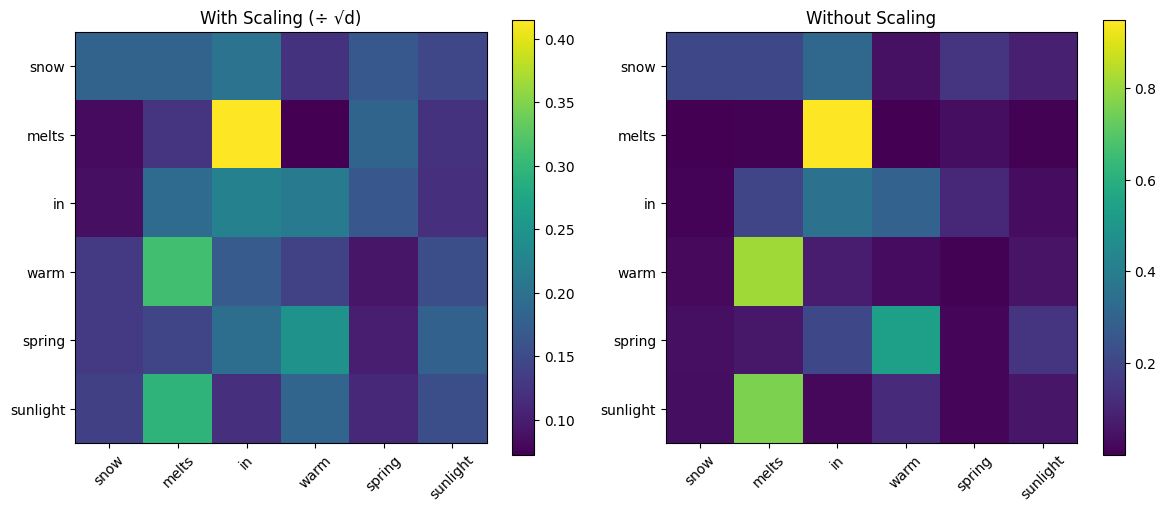

In [18]:
# plot heatmaps 
fig, axes = plt.subplots(1,2, figsize=(12,5))

im1 = axes[0].imshow(weights_scaled.detach().numpy())
axes[0].set_title("With Scaling (÷ √d)")
plt.colorbar(im1, ax=axes[0])

im2 = axes[1].imshow(weights_noscale.detach().numpy())
axes[1].set_title("Without Scaling")
plt.colorbar(im2, ax=axes[1])

for ax in axes:
    ax.set_xticks(range(seq_len))
    ax.set_yticks(range(seq_len))
    ax.set_xticklabels(tokens, rotation=45)
    ax.set_yticklabels(tokens)

plt.tight_layout()
plt.savefig("C:\\Users\\mamar\\portfolio-piece-1-mmarchio29\\attention-portfolio\\outputs\\scaling.png", dpi=300, bbox_inches="tight")
plt.show()

### Positional Encoding

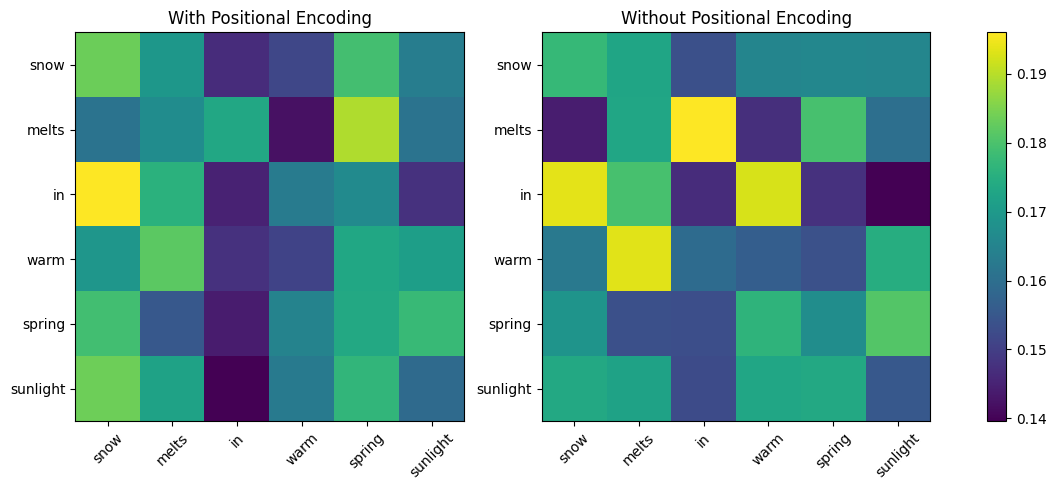

In [20]:
avg_with_pos = weights_pos.mean(dim=1)[0]
avg_no_pos = weights_no_pos.mean(dim=1)[0]

fig, axes = plt.subplots(1,2, figsize=(12,5))

axes[0].imshow(avg_with_pos.detach().numpy(), cmap="viridis")
axes[0].set_title("With Positional Encoding")

axes[1].imshow(avg_no_pos.detach().numpy(), cmap="viridis")
axes[1].set_title("Without Positional Encoding")

for ax in axes:
    ax.set_xticks(range(seq_len))
    ax.set_yticks(range(seq_len))
    ax.set_xticklabels(tokens, rotation=45)
    ax.set_yticklabels(tokens)

plt.tight_layout()
plt.colorbar(ax.images[0], ax=axes.ravel().tolist())
plt.savefig("C:\\Users\\mamar\\portfolio-piece-1-mmarchio29\\attention-portfolio\\outputs\\pe.png", dpi=300, bbox_inches="tight")
plt.show()

### Softmax

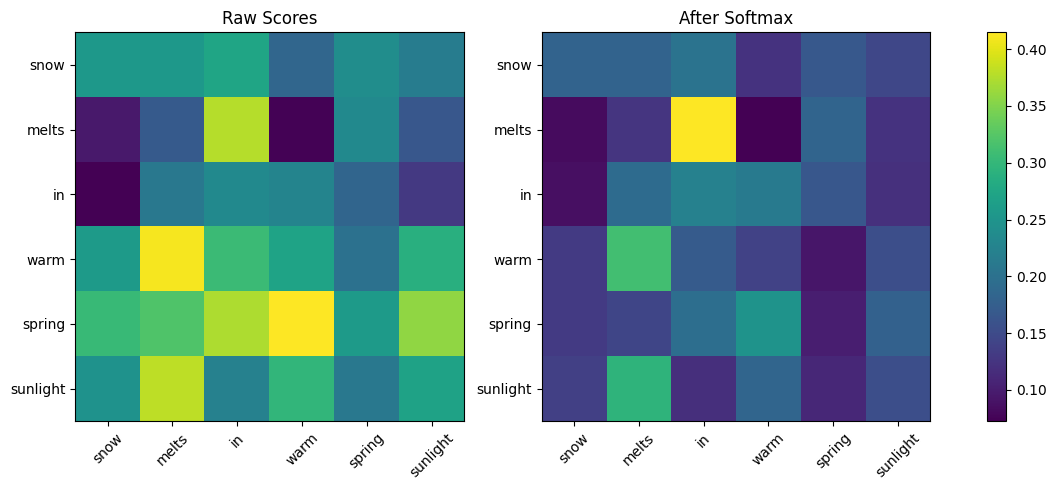

In [22]:
_, weights, raw_scores = mha(X_with_pos, return_scores=True)

head = 0
raw = raw_scores[0, head]
soft = weights[0, head]

fig, axes = plt.subplots(1,2, figsize=(12,5))

axes[0].imshow(raw.detach().numpy(), cmap="viridis")
axes[0].set_title("Raw Scores")

axes[1].imshow(soft.detach().numpy(), cmap="viridis")
axes[1].set_title("After Softmax")

for ax in axes:
    ax.set_xticks(range(seq_len))
    ax.set_yticks(range(seq_len))
    ax.set_xticklabels(tokens, rotation=45)
    ax.set_yticklabels(tokens)

plt.tight_layout()
plt.colorbar(ax.images[0], ax=axes.ravel().tolist())
plt.savefig("C:\\Users\\mamar\\portfolio-piece-1-mmarchio29\\attention-portfolio\\outputs\\softmax.png", dpi=300, bbox_inches="tight")
plt.show()

In [23]:
row_sums = weights_pos[0,0].sum(dim=-1)
print("Row sums (Head 1):", row_sums)

Row sums (Head 1): tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       grad_fn=<SumBackward1>)


### Runtime Analysis

In [24]:
import time

def measure_attention_time(seq_len, embed_dim=64, num_heads=4):
    x = torch.randn(1, seq_len, embed_dim)
    mha = MultiHeadAttention(embed_dim, num_heads)
    
    start = time.time()
    mha(x)
    end = time.time()
    
    return end - start

In [25]:
lengths = [8, 16, 32, 64, 128, 256]
times = []

for L in lengths:
    t = measure_attention_time(L)
    times.append(t)
    print(f"Length {L}: {t:.6f} sec")

Length 8: 0.001981 sec
Length 16: 0.001785 sec
Length 32: 0.013540 sec
Length 64: 0.004951 sec
Length 128: 0.009399 sec
Length 256: 0.005403 sec


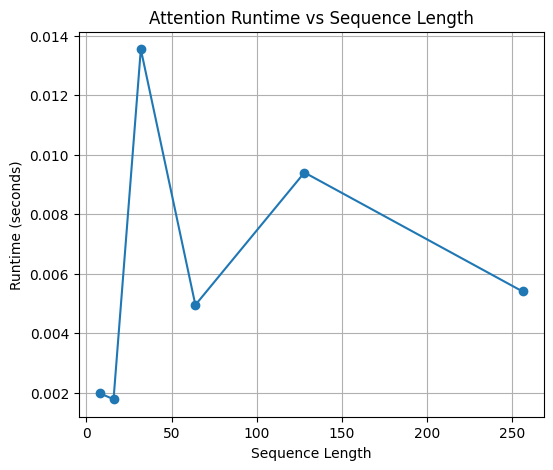

In [26]:
plt.figure(figsize=(6,5))
plt.plot(lengths, times, marker='o')
plt.xlabel("Sequence Length")
plt.ylabel("Runtime (seconds)")
plt.title("Attention Runtime vs Sequence Length")
plt.grid(True)
plt.savefig("C:\\Users\\mamar\\portfolio-piece-1-mmarchio29\\attention-portfolio\\outputs\\runtime.png", dpi=300, bbox_inches="tight")
plt.show()